# Collecting Data 

In [ ]:
import os

import cv2


DATA_DIR = './data'
if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)

number_of_classes = 5
dataset_size = 100

cap = cv2.VideoCapture(0)
for j in range(number_of_classes):

    if not os.path.exists(os.path.join(DATA_DIR, str(j))):
        os.makedirs(os.path.join(DATA_DIR, str(j)))

    print('Collecting data for class {}'.format(j))

    done = False
    while True:
        ret, frame = cap.read()
        cv2.putText(frame, 'Ready? Press "Q" ! :)', (100, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.3, (0, 255, 0), 3,
                    cv2.LINE_AA)
        cv2.imshow('frame', frame)
        if cv2.waitKey(25) == ord('q'):
            break

    counter = 0
    while counter < dataset_size:
        ret, frame = cap.read()
        cv2.imshow('frame', frame)
        cv2.waitKey(25)
        cv2.imwrite(os.path.join(DATA_DIR, str(j), '{}.jpg'.format(counter)), frame)

        counter += 1

cap.release()
cv2.destroyAllWindows()



# You can check the collected data

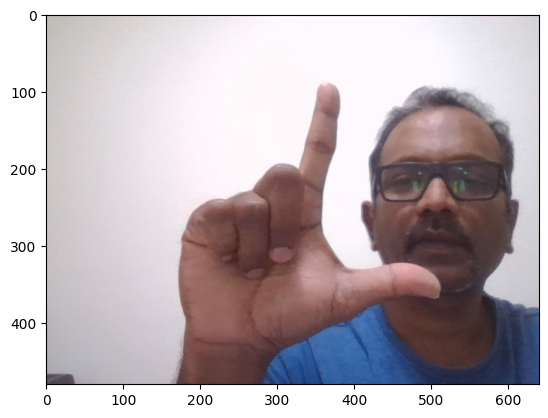

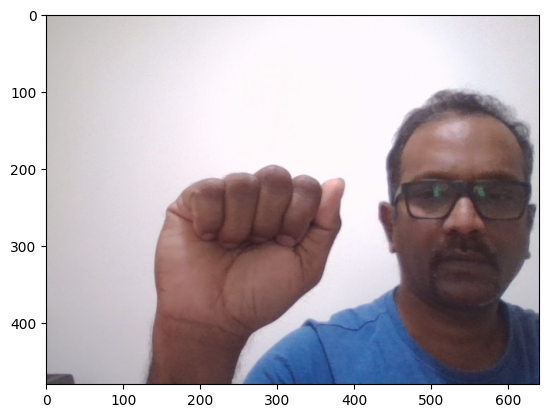

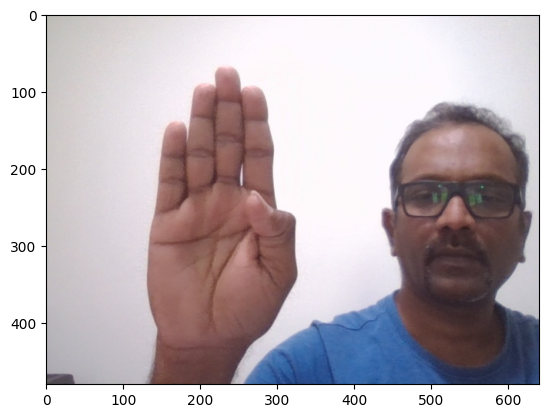

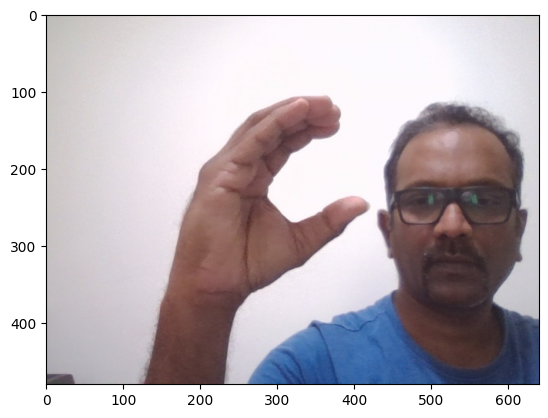

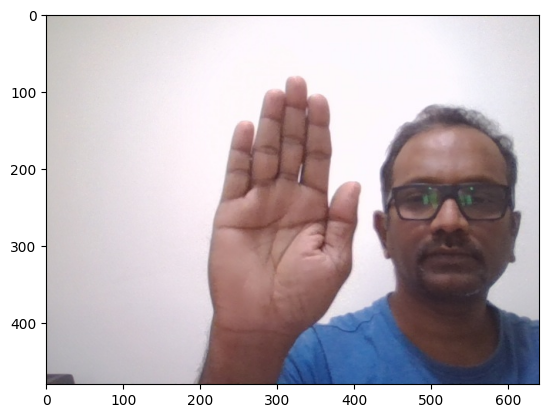

In [1]:
import os
import pickle
import mediapipe as mp
import cv2
import matplotlib.pyplot as plt

DATA_DIR= './data'
for dir_ in os.listdir(DATA_DIR):
    dir_path = os.path.join(DATA_DIR, dir_)
    if os.path.isdir(dir_path):
        
        for img_path in os.listdir(dir_path)[:1]:
            img=cv2.imread(os.path.join(dir_path, img_path))
        #img=cv2.imread(os.path.join(DATA_DIR,dir_,img_path))
        #img_rgb=cv2.cvtColor(img,cv2.COLOR_RGB2RGB)
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.figure()
        plt.imshow(img_rgb)

plt.show()

# Check the mapping of the collected data
## MediaPipe and OpenCV (CV) work together to process images for hand detection and visualization

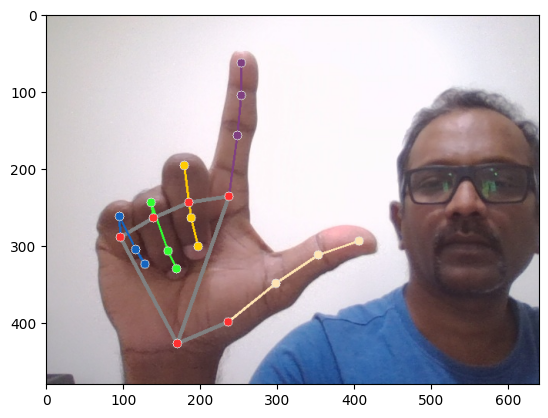

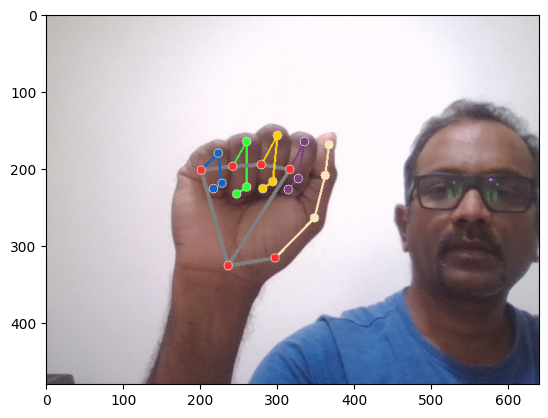

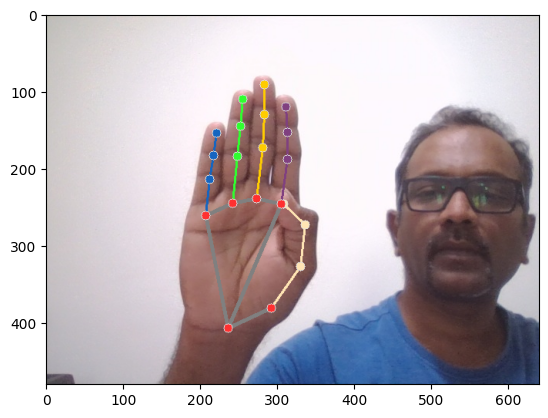

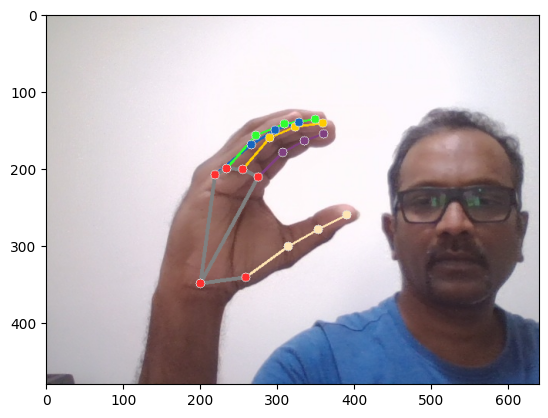

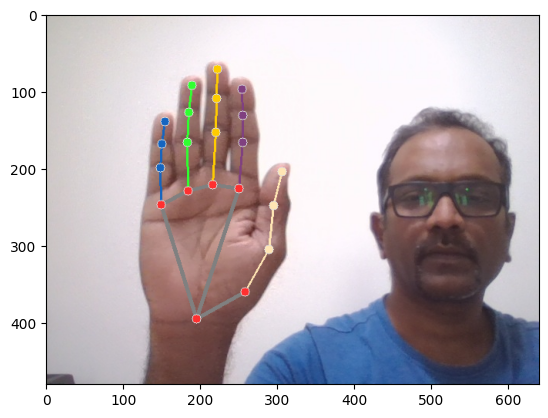

In [2]:
import os
import cv2
import matplotlib.pyplot as plt
import mediapipe as mp

mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

hands = mp_hands.Hands(static_image_mode=True, min_detection_confidence=0.3)

DATA_DIR = './data'
for dir_ in os.listdir(DATA_DIR):
    dir_path = os.path.join(DATA_DIR, dir_)
    if os.path.isdir(dir_path):
        for img_path in os.listdir(dir_path)[:1]:
            for img_path in os.listdir(dir_path):
                img = cv2.imread(os.path.join(dir_path, img_path))
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            results = hands.process(img_rgb)
            if results.multi_hand_landmarks:
                for hand_landmarks in results.multi_hand_landmarks:
                    mp_drawing.draw_landmarks(
                        img,
                        hand_landmarks,
                        mp_hands.HAND_CONNECTIONS,
                        mp_drawing_styles.get_default_hand_landmarks_style(),
                        mp_drawing_styles.get_default_hand_connections_style())
            
            plt.figure()
            plt.imshow(img[:, :, ::-1])  # Convert the image back to RGB for display
            plt.show()
            
        

# Save the dataset to use for training the machine learning models

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
import mediapipe as mp
import pickle

mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

hands = mp_hands.Hands(static_image_mode=True, min_detection_confidence=0.3)

DATA_DIR = './data'
data = []
labels = []
for dir_ in os.listdir(DATA_DIR):
    dir_path = os.path.join(DATA_DIR, dir_)
    if os.path.isdir(dir_path):
        for img_path in os.listdir(dir_path):
            data_aux = []
            img = cv2.imread(os.path.join(dir_path, img_path))
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            results = hands.process(img_rgb)
            if results.multi_hand_landmarks:
                for hand_landmarks in results.multi_hand_landmarks:
                    for i in range(len(hand_landmarks.landmark)):
                        x = hand_landmarks.landmark[i].x
                        y = hand_landmarks.landmark[i].y
                        data_aux.append(x)
                        data_aux.append(y)
                data.append(data_aux)
                labels.append(dir_)

f = open('data.pickle', 'wb')
pickle.dump({'data': data, 'labels': labels}, f)
f.close()

# Check the collected data

In [ ]:
import pickle
data_dict=pickle.load(open('./data.pickle','rb'))
print(data_dict.keys())
print(data_dict)


# Traing the Classifier 

In [ ]:
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np

data_dict=pickle.load(open('./data.pickle','rb'))
data = np.asarray(data_dict['data'])
labels = np.asarray(data_dict['labels'])

x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, shuffle=True, stratify=labels)

model = RandomForestClassifier()

model.fit(x_train, y_train)

y_predict = model.predict(x_test)

score = accuracy_score(y_predict, y_test)

print('{}% of samples were classified correctly !'.format(score * 100))

f = open('model.p', 'wb')
pickle.dump({'model': model}, f)
f.close()

# Real-time hand gesture recognition using a pre-trained machine learning model.

## It captures video frames from the webcam, detects hand landmarks using MediaPipe, and predicts the corresponding hand gesture or sign based on the detected landmarks.

In [ ]:
import pickle
import cv2
import mediapipe as mp
import numpy as np

model_dict = pickle.load(open('./model.p', 'rb'))
model = model_dict['model']

cap = cv2.VideoCapture(0)

mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

hands = mp_hands.Hands(static_image_mode=True, min_detection_confidence=0.3)
labels_dict = {0: 'L', 1: 'A', 2: 'B', 3: 'c', 4: 'Hello'}

while True:
    data_aux = []

    ret, frame = cap.read()

    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    results = hands.process(frame_rgb)
    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            mp_drawing.draw_landmarks(
                frame,
                hand_landmarks,
                mp_hands.HAND_CONNECTIONS,
                mp_drawing_styles.get_default_hand_landmarks_style(),
                mp_drawing_styles.get_default_hand_connections_style())

            for i in range(len(hand_landmarks.landmark)):
                x = hand_landmarks.landmark[i].x
                y = hand_landmarks.landmark[i].y
                data_aux.append(x)
                data_aux.append(y)

    if data_aux:
        prediction = model.predict([np.asarray(data_aux)])
        predicted_character = labels_dict[int(prediction[0])]
        print(predicted_character)
        # Process the prediction as needed
    else:
        print("No hand landmarks detected in the current frame.")

    cv2.imshow('frame', frame)

    # Wait for the 'q' key press to stop the program
    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()